# Detect one hand finger's number using Tensorflow

In this notebook, we will train a Neural Network using Tensorflow to detect on an image which number is done using fingers. At the end of the notebook, we'll save the parameters in a $.npy$ format.

## Organization of this Notebook 
    1. Packages
    2. Load and prepare data set
    3. Tensorflow's required functions
    4. Save and load functions for the parameters
    5. Construct, train and save the model

## 1 - Packages ##

In [24]:
import numpy as np
import cv2 # Used for color conversion
import matplotlib.pyplot as plt
import tensorflow as tf
import os # Used to read, open and create files
from IPython.display import clear_output # Used at the end for the demo
from py_utils import load_dataset, random_mini_batches

%matplotlib inline

## 2 -  Load and prepare data set ##

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [3]:
#convert to gray
X_train_orig_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in X_train_orig])
X_test_orig_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in X_test_orig])

### a. Images

Images of size: (64, 64)


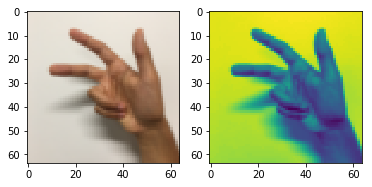

In [4]:
plt.figure()

plt.subplot(1,2,1)
plt.imshow(X_train_orig[100])
plt.subplot(1,2,2)
plt.imshow(X_train_orig_gray[100])
print("Images of size: " + str(X_train_orig_gray[100].shape))

We reshape and normalize the images to have a $(height*width*3 \text{ x } 1)$ matrix with pixels values between $0$ and $1$.

In [5]:
X_train = X_train_orig.reshape(X_train_orig.shape[0], -1).T / 255.
X_test = X_test_orig.reshape(X_test_orig.shape[0], -1).T / 255.

X_train_gray = X_train_orig_gray.reshape(X_train_orig_gray.shape[0], -1).T / 255.
X_test_gray = X_test_orig_gray.reshape(X_test_orig_gray.shape[0], -1).T / 255.

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
X_test shape: (12288, 120)


### b. Labels

Y_train_orig shape: (1, 1080)
Y_test_orig shape: (1, 120)


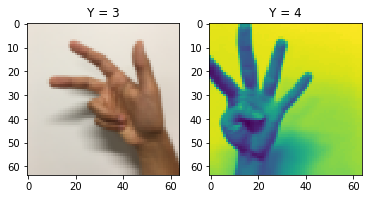

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_train_orig[100])
plt.title("Y = " + str(np.squeeze(Y_train_orig[:, 100])))
plt.subplot(1,2,2)
plt.imshow(X_test_orig_gray[50])
plt.title("Y = " + str(np.squeeze(Y_test_orig[:, 50])))

print ("Y_train_orig shape: " + str(Y_train_orig.shape))
print ("Y_test_orig shape: " + str(Y_test_orig.shape))

Currently, the labels contains a number between 0 and 5. We reshape the labels to fit the following:
<img src="images/hands.png">

In [7]:
def convertLabels(Y, size):
    Labels = np.eye(size)[Y.reshape(-1)].T
    return Labels

In [8]:
Y_train = convertLabels(Y_train_orig, 6)
Y_test = convertLabels(Y_test_orig, 6)

Y_train shape: (6, 1080)
Y_test shape: (6, 120)


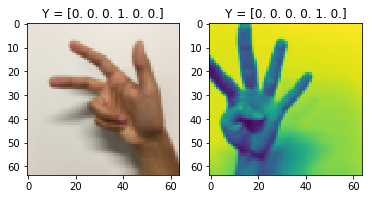

In [9]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_train_orig[100])
plt.title("Y = " + str(Y_train[:, 100]))
plt.subplot(1,2,2)
plt.imshow(X_test_orig_gray[50])
plt.title("Y = " + str(Y_test[:, 50]))

print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

## 3 - Tensorflow's required functions ##

In [10]:
def initialize(layerDims):
    
    L = len(layerDims)
    parameters = {}
    
    for l in range(1,L):
        n1 = layerDims[l]
        n0 = layerDims[l-1]
        
        W_string = 'W' + str(l)
        b_string = 'b' + str(l)
        
        parameters[W_string] = tf.get_variable(W_string, [n1,n0], initializer = tf.contrib.layers.xavier_initializer())
        parameters[b_string] = tf.get_variable(b_string, [n1,1], initializer = tf.zeros_initializer())
        print(W_string + str(parameters[W_string]))
        print(b_string + str(parameters[b_string]))
    
    return parameters

In [11]:
def forwardPropagation(X, parameters, actFunctions):
    
    L = len(parameters) // 2
    
    assert(L == len(actFunctions))
    
    A = X
    
    for l in range(L):
        W = parameters['W' + str(l+1)]
        b = parameters['b' + str(l+1)]
        
        # Z = np.dot(W, A) + b
        Z = tf.add(tf.matmul(W, A), b)
        
        if (actFunctions[l] == "ReLU"):
            A = tf.nn.relu(Z)
    
    Z = tf.add(tf.matmul(W, A), b)
    return Z

In [12]:
def computeCost(Z, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

## 4 - Save and load functions for the parameters ##

In [13]:
def saveParameters(parameters, folderName = ""):
    if not os.path.exists("parameters/"):
        os.mkdir("parameters")
        
    L = len(parameters) // 2
    path = "parameters/" + folderName + "/"
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    for l in range(L):
        np.save(path + 'W' + str(l+1), parameters['W' + str(l+1)])
        np.save(path + 'b' + str(l+1), parameters['b' + str(l+1)])

In [14]:
def loadParameters(folderName = ""):
    parameters = {}
    path = "parameters/" + folderName + "/"
    
    for entry in os.listdir(path):
        if os.path.isfile(os.path.join(path, entry)):
            if entry[-4:] == ".npy":
                parameters[entry[:-4]] = np.load(os.path.join(path, entry))
    
    return parameters

## 5 - Construct, train and save the models ##

In [15]:
def model(X_train, Y_train, X_test, Y_test, layerDims, actFunctions, learning_rate = 0.0001,
          num_epochs = 3000, minibatch_size = 32, print_cost = True):
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    
    assert(layerDims[0] == n_x)
    assert(layerDims[len(layerDims) - 1] == n_y)
    
    costs = []
    
    tf.reset_default_graph()
    
    # Create tf Placeholders
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = "Y")

    parameters = initialize(layerDims)
    
    # Build the forward propagation in the tensorflow graph
    Z = forwardPropagation(X, parameters, actFunctions)
    
    # Add cost function to tensorflow graph)
    cost = computeCost(Z, Y)
    
    # Define the tensorflow optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the "optimizer" and the "cost"
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost = epoch_cost + minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [16]:
layerDimsRGB = [X_train.shape[0], 25, 12, 6]
layerDimsGray = [X_train_gray.shape[0], 25, 12, 6]
actFunctions = ["ReLU", "ReLU", "output"]

W1<tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1<tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2<tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2<tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3<tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3<tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 1.878220
Cost after epoch 100: 1.287878
Cost after epoch 200: 1.171642
Cost after epoch 300: 1.102292
Cost after epoch 400: 1.042824
Cost after epoch 500: 0.996874
Cost after epoch 600: 0.945346
Cost after epoch 700: 0.884511
Cost after epoch 800: 0.836306
Cost after epoch 900: 0.789611
Cost after epoch 1000: 0.745242
Cost after epoch 1100: 0.693381
Cost after epoch 1200: 0.644458
Cost after epoch 1300: 0.591901
Cost after epoch 1400: 0.548556
Cost a

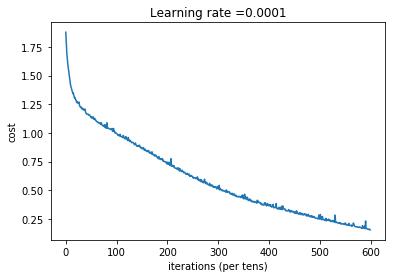

Parameters have been trained!
Train Accuracy: 0.96018517
Test Accuracy: 0.625


In [17]:
parametersRGB = model(X_train, Y_train, X_test, Y_test, layerDimsRGB, actFunctions)

saveParameters(parametersRGB, "RGB")

W1<tf.Variable 'W1:0' shape=(25, 4096) dtype=float32_ref>
b1<tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2<tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2<tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3<tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3<tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>
Cost after epoch 0: 1.891524
Cost after epoch 100: 1.327682
Cost after epoch 200: 1.067275
Cost after epoch 300: 0.850764
Cost after epoch 400: 0.725993
Cost after epoch 500: 0.632484
Cost after epoch 600: 0.570827
Cost after epoch 700: 0.491801
Cost after epoch 800: 0.438699
Cost after epoch 900: 0.397377
Cost after epoch 1000: 0.347904
Cost after epoch 1100: 0.290083
Cost after epoch 1200: 0.250323
Cost after epoch 1300: 0.203563
Cost after epoch 1400: 0.177549
Cost after epoch 1500: 0.151054
Cost after epoch 1600: 0.121934
Cost after epoch 1700: 0.092200
Cost after epoch 1800: 0.077069
Cost after epoch 1900: 0.061922
Cost after epoch 2000: 0.048887
Cost af

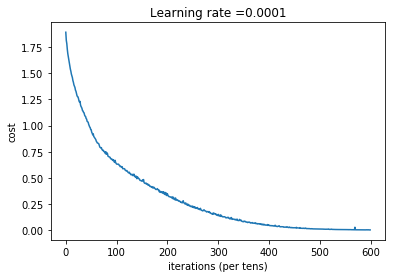

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.71666664


In [18]:
parametersGray = model(X_train_gray, Y_train, X_test_gray, Y_test, layerDimsGray, actFunctions)

saveParameters(parametersGray, "GRAY")

## 6 - Test the model ##

In [19]:
def forwardPropagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2) 
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [20]:
def predictTensorflow(X, parameters):
    
    x = tf.placeholder("float", [X.shape[0], 1])
    
    z3 = forwardPropagation(x, parameters)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
    sess.close()
    
    return prediction

In [25]:
def demo(X_RGB, paramsRGB, X_GRAY, paramsGRAY):
    
    try:
        while(True):
            # Randomly select pictures
            indexRGB = np.random.randint(X_RGB.shape[0])
            indexGRAY = np.random.randint(X_GRAY.shape[0])
            
            imgRGB = X_RGB[indexRGB].reshape((1, 64*64*3)).T
            imgGRAY = X_GRAY[indexGRAY].reshape((1, 64*64)).T
            
            plt.figure()
            
            plt.subplot(1,2,1)
            plt.title("Predicted with RGB:\n" + str(np.squeeze(predictTensorflow(imgRGB, paramsRGB))))
            plt.imshow(X_RGB[indexRGB])
            plt.axis('off')
            
            plt.subplot(1,2,2)
            plt.title("Predicted with GRAY:\n" + str(np.squeeze(predictTensorflow(imgGRAY, paramsGRAY))))
            plt.imshow(X_GRAY[indexGRAY])
            plt.axis('off')

            plt.show()
            
            # Display the images until new ones are available
            clear_output(wait=True)
    except KeyboardInterrupt:
        print("Demo ended")

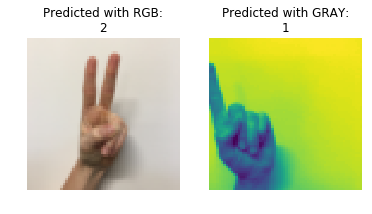

In [ ]:
paramsRGB = loadParameters("RGB")
paramsGRAY = loadParameters("GRAY")
demo(X_train_orig, paramsRGB, X_train_orig_gray, paramsGRAY)